In [1]:
import os
import scipy.io as sio
import mat73
import numpy as np
import copy
from SRDWI import get_mgrid, ImageFitting_set, Siren, PN, input_mapping
from tqdm import tqdm
import itertools
from multiprocessing import Pool
import torch
import matplotlib.pyplot as plt
from skimage.transform import rescale
from IPython import display
from scipy.interpolate import interp1d

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="3"

data_address = '/home/gundogdu/Downloads/pat099/master.mat'
print('Loading data')
try:
    data = sio.loadmat(data_address)
except NotImplementedError:
    data = mat73.loadmat(data_address) 
print('Data loaded')
hybrid_raw = data['hybrid_raw']
image_shape = hybrid_raw[0][0].shape

acquisitions = np.zeros((image_shape[0], 
                  image_shape[1], 
                  image_shape[2],
                  4,
                  hybrid_raw[1][0].shape[3]*hybrid_raw[2][0].shape[3]*hybrid_raw[3][0].shape[3]))




Loading data
Data loaded


In [3]:

def calculate_ADC(bvalues, slicedata):
    min_adc = 0
    max_adc = 3.0
    eps = 1e-7
    numrows, numcols, _ = slicedata.shape
    adc_map = np.zeros((numrows, numcols))
    for row in range(numrows):
        for col in range(numcols):
            ydata = np.squeeze(slicedata[row, col, :])
            adc = np.polyfit(bvalues.flatten()/1000, np.log(ydata + eps), 1)
            adc = -adc[0]
            adc_map[row, col] =  max(min(adc, max_adc), min_adc)
    return adc_map


def calculate_combinations(voxel):
    i, j, k = voxel
    te = 1 # Note we are choosing TE=70ms becuase it is the one closest to the clinical DWI
    b0 = [hybrid_raw_norm[0][te][i, j, k]]
    b1 = [x for x in hybrid_raw_norm[1][te][i, j, k, :]]
    b2 = [x for x in hybrid_raw_norm[2][te][i, j, k, :]]
    b3 = [x for x in hybrid_raw_norm[3][te][i, j, k, :]]
    all_bs = [b0, b1, b2, b3]
    combs = np.asarray(list(itertools.product(*all_bs))).T
    return combs
    
def resize_array(arr, new_size=128, kind='cubic'):
    old_shape = arr.shape
    new_shape = (old_shape[0], old_shape[1], new_size)
    new_arr = np.zeros(new_shape)
    x_old = np.linspace(0, 1, old_shape[2])
    x_new = np.linspace(0, 1, new_size)
    f = interp1d(x_old, arr, kind=kind, axis=2)
    for i in range(new_size):
        new_arr[:, :, i] = f(x_new[i])
    return new_arr

hybrid_raw_norm = copy.deepcopy(hybrid_raw)
maxes = np.zeros((4,4))

for b in range(4):
    for te in range(4):
        maxes[b, te] = hybrid_raw_norm[b][te].max()
        hybrid_raw_norm[b][te] = hybrid_raw_norm[b][te]/maxes[b, te]
   
num_processes = 32
pool = Pool(processes=num_processes)
voxel_list = [(i, j, k) for i in range(image_shape[0])
                             for j in range(image_shape[1])
                             for k in range(image_shape[2])]

results = pool.map(calculate_combinations, voxel_list)
pool.close()
pool.join()
for idx, voxel in enumerate(voxel_list):
    i, j, k = voxel
    acquisitions[i, j, k, :, :] = results[idx]


select_acquisitions = np.squeeze(acquisitions)

mean_img = np.mean(select_acquisitions,-1)

img_dataset = []
for inx in range(select_acquisitions.shape[-1]):
    img = select_acquisitions[40:90:2, 40:90:2, :, :, inx]
    img_dataset.append(img)

mean_dataset = ImageFitting_set([mean_img[40:90:2, 40:90:2, :]])
dataset = ImageFitting_set(img_dataset)
HR = ImageFitting_set([mean_img])

print('Done---!')


/home/gundogdu/inr3/lib64/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Done---!


0.08012824444297541


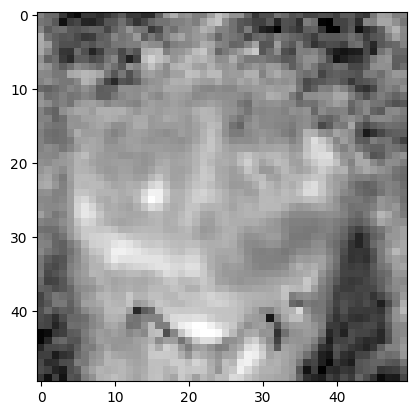

In [4]:
bvalues = data['b']
raw_mean = np.zeros((50, 50, 4))
for b in range(4):
    raw_mean[:, : , b] = np.mean(hybrid_raw[b][1][40:90, 40:90, 10, :], -1)*maxes[b, 1] if b else hybrid_raw[b][1 ][40:90, 40:90, 10]*maxes[b, 1]

#bvalues = np.asarray((0, 1500))
adc = calculate_ADC(bvalues, raw_mean)
print(adc.min())
plt.imshow(adc,  vmin=0.3, vmax = 3., cmap='gray')

100%|██████████| 2000/2000 [00:32<00:00, 61.66it/s] 


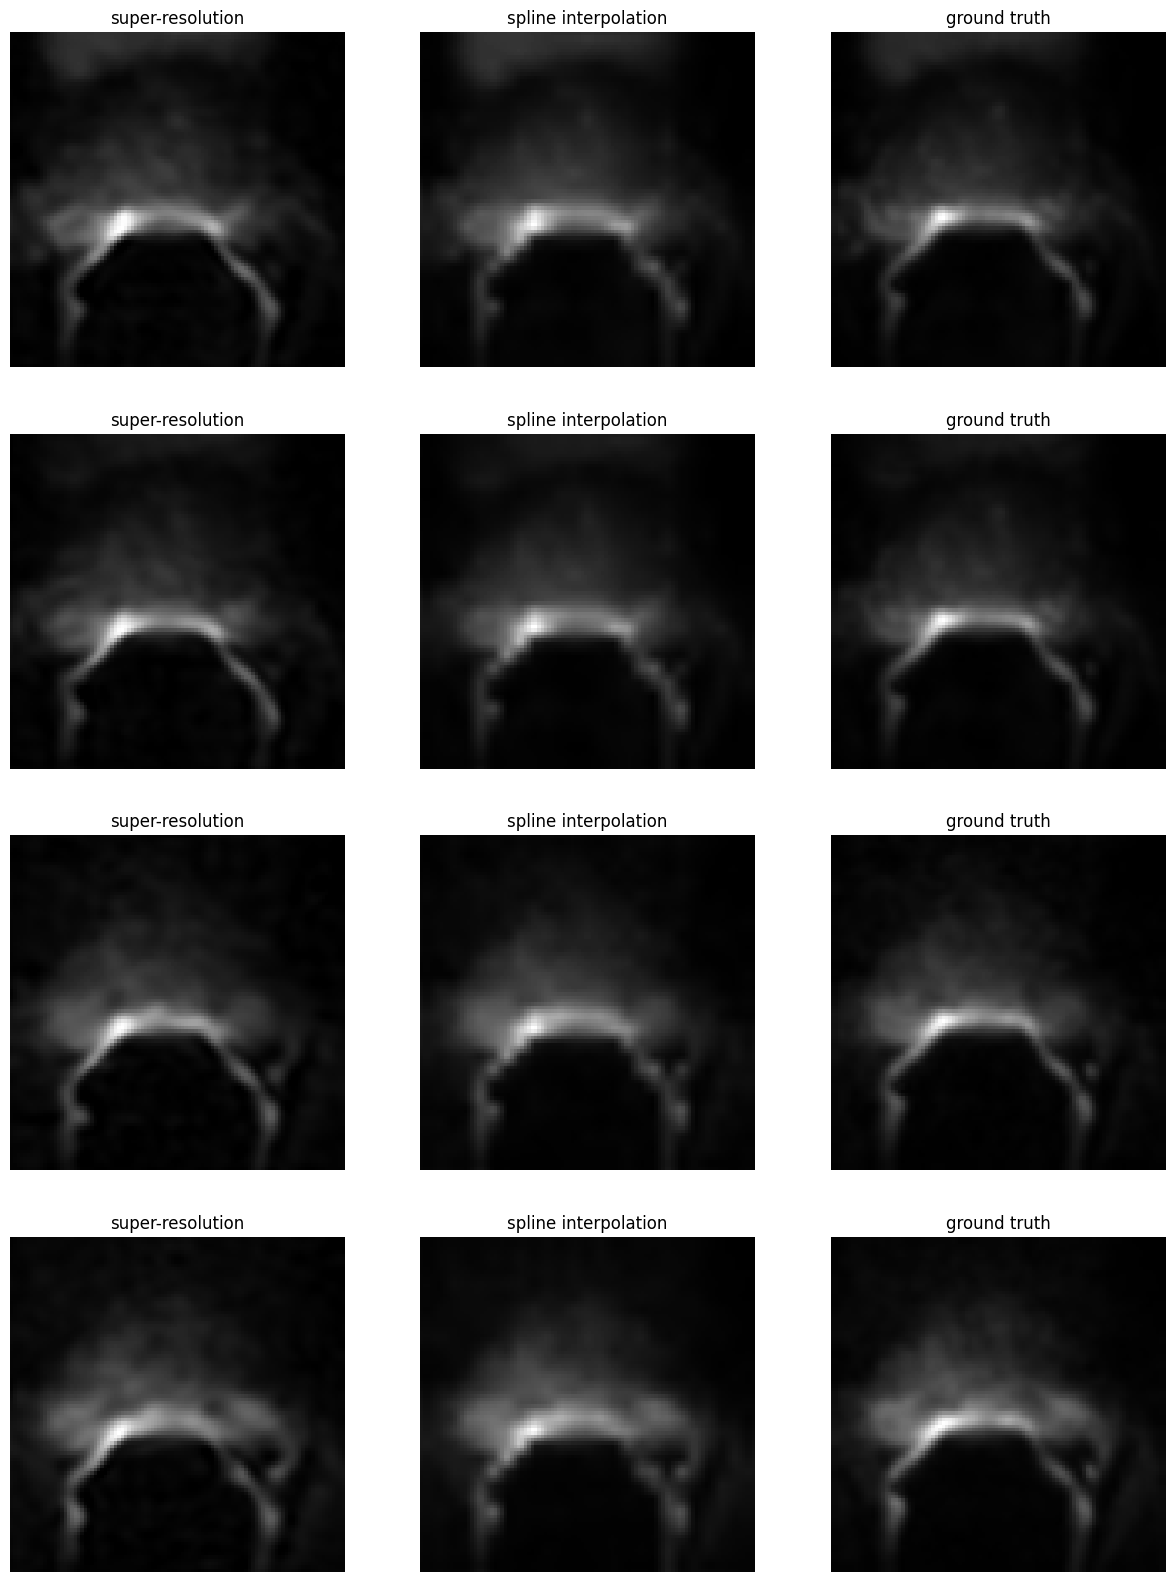

In [19]:
mapping_size = 128
scale = 0.5
dimension = len(dataset.shape)

B_gauss = np.random.normal(size=(mapping_size, dimension))
B = torch.from_numpy(B_gauss * scale).float().cuda()

INR = Siren(in_features=2*mapping_size, out_features=1, 
                    hidden_features=128,
                    hidden_layers=3)
INR.cuda()
PerturbNet = PN(in_features=2*mapping_size, hidden_features=128, dimension=dimension)
PerturbNet.cuda()

inr_params = list(INR.parameters())
inr_optim = torch.optim.Adam(lr=1e-4, params=inr_params)
perturb_params = list(PerturbNet.parameters())
perturb_optim = torch.optim.Adam(lr=1e-6, params=perturb_params)
torch.cuda.empty_cache()

LR_ground_truth, model_input  = mean_dataset.pixels[0], mean_dataset.coords[0]
LR_ground_truth, model_input = LR_ground_truth.cuda(), model_input.cuda()
model_input = input_mapping(model_input, B)
#LR_ground_truth /= LR_ground_truth.max()
HR_ground_truth, HR_model_input  = HR.pixels[0], HR.coords[0]
HR_ground_truth, HR_model_input = HR_ground_truth.cuda(), HR_model_input.cuda()
HR_model_input = input_mapping(HR_model_input, B)
#HR_ground_truth /= HR_ground_truth.max()
test_input  = input_mapping(get_mgrid((100, 100, 25, 4)).cuda(), B)

img_ctr = 0
for ctr in tqdm(range(2000)):

    if ctr < 1950:
        model_output = INR.forward(model_input)
        loss = ((model_output - LR_ground_truth)**2).mean()
        inr_optim.zero_grad()
        loss.backward()
        inr_optim.step()

    else:
        if ctr%2:
            model_output = INR.forward(model_input)
            loss = ((model_output - LR_ground_truth)**2).mean()
            inr_optim.zero_grad()
            loss.backward()
            inr_optim.step()
        else:
            for sample in range(len(dataset)):
                ground_truth  = dataset.pixels[sample]
                ground_truth = ground_truth.cuda()
                ground_truth /= ground_truth.max()
                perturbed_input = PerturbNet.forward(model_input, sample, 1/128.)
                perturbed_input = input_mapping(perturbed_input, B)
                model_output = INR.forward(perturbed_input)

                loss = ((model_output - ground_truth)**2).mean()
                perturb_optim.zero_grad()
                loss.backward()
                perturb_optim.step()
                # if not sample:
                #     loss = ((model_output - ground_truth)**2).mean()
                # else:
                #     loss += ((model_output - ground_truth)**2).mean()
        


recon = torch.clamp(INR.forward(test_input), min=0).cpu().view(100, 100, 25, 4).detach().numpy()

fig, ax = plt.subplots(4,3,figsize=(15,20))

for b in range(4):
    ax[b, 0].imshow(recon[:, :, 16, b], cmap='gray')
    ax[b, 0].set_title('super-resolution')
    ax[b, 1].imshow(rescale(mean_img[40:90:2, 40:90:2, 16, b], 4), cmap='gray')
    ax[b, 1].set_title('spline interpolation')
    ax[b, 2].imshow(rescale(mean_img[40:90, 40:90, 16, b], 2), cmap='gray')
    ax[b, 2].set_title('ground truth')

#ax[2].set_aspect(128/28)
for axi in range(3):
    for axj in range(4):
        ax[axj, axi].axis('off')

    #    model_output = INR.forward(HR_model_input)
    #    loss = ((model_output - HR_ground_truth)**2).mean()
    #    print(f'epoch = {ctr}, val loss = {loss.item()}')




In [74]:
from skimage.metrics import structural_similarity as ssim
for _slice in range(9,17):
    b = 3
    SR = recon[::2, ::2, _slice, b]  
    SR = SR/SR.max()
    inter = rescale(mean_img[40:90:2, 40:90:2, _slice, b], 2)
    inter = inter/inter.max()
    HR_ref = mean_img[40:90, 40:90, _slice, b]
    HR_ref = HR_ref/HR_ref.max()
    bin_map = (HR_ref>0.05)
    bin_map2 = (HR_ref<.5)
    BM = bin_map*bin_map2
    print(_slice, ssim(HR_ref*BM, SR*BM, data_range=1), ssim(HR_ref*BM, inter*BM, data_range=1))


9 0.8631243927156065 0.9228482096341593
10 0.8598738203879933 0.9013182440975311
11 0.852418423270024 0.8890362839540821
12 0.8412170147641846 0.8997956187613442
13 0.8835740302253831 0.9406501313542465
14 0.8999819646357821 0.927014511383249
15 0.909967204464298 0.9193383002987079
16 0.8967572289710312 0.9326221475132378


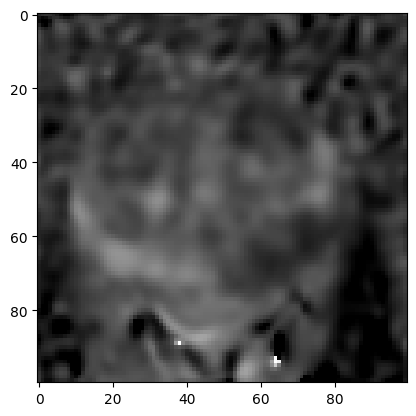

In [9]:
bvalues = data['b']
raw_mean = np.zeros((100, 100, 4))
for b in range(4):
    raw_mean[:, : , b] = (recon[:, :, 10, b])*maxes[b, 1]

#bvalues = np.asarray((0, 1500))
adc = calculate_ADC(bvalues, raw_mean)
plt.imshow(adc,  vmin=0.3, vmax = 3., cmap='gray')

In [ ]:
print(dataset.pixels[0].shape[0]/mean_dataset.pixels[0].shape[0])

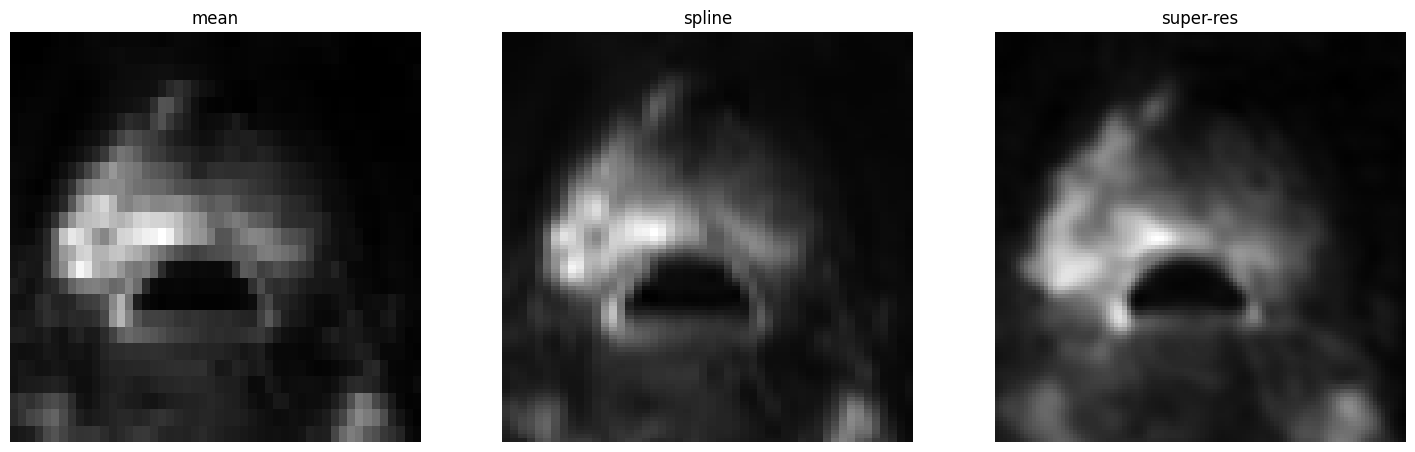

In [17]:
torch.cuda.empty_cache
model_input  = get_mgrid((100, 100, 100, 1)).cuda()
model_input  = input_mapping(model_input, B)
recon = INR.forward(model_input).cpu().view(100,100, 100, 1).detach().numpy()
fig, ax = plt.subplots(1, 3, figsize=(18,6))
_slice = 71
ax[2].imshow(recon[(_slice - 40)*2, :, :, 0].T, cmap='gray')
ax[2].set_title(f'super-res')
spline = resize_array(mean_img[:, :, :, 0], 100)
ax[1].imshow(spline[_slice, 40:90 , :].T, cmap='gray')
ax[1].set_aspect(50/100)
ax[1].set_title('spline')
ax[0].imshow(mean_img[_slice, 40:90, :, 0 ].T, cmap='gray')
ax[0].set_title('mean')
ax[0].set_aspect(100/50)
for axi in range(3):
    ax[axi].axis('off')

## TODO

1. Change the B3 one slice only without PIL.Image (done)
2. Number 1 plus 3D (done)
3. Number 2 plus multiple acquisitions (done)
4. Observe ground truth error (done)
5. Number 3 plus multiple b-values unregistered (done)
6. Number 4 plus ERD on high-b (later)
7. Undo the normalization for ADC
8. Automate the whole god damn thing
9. Number 5 plus registration
10. Number 9 plus not showing the PIDS regions


In [ ]:
accept = (1/acquisitions.shape[-1])*np.ones((acquisitions.shape))
mul, slope = 1000, 20

print('Conducting Soft-ERD and calculating weights...')
for i in range(acquisitions.shape[0]):
    for j in range(acquisitions.shape[1]):
        x = acquisitions[i, j, :]
        b_zero = b0[i,j]
        if np.mean(x)>20:
            temp = max(mul*np.exp(-slope*(np.mean(x)/b_zero)), 2) #if temp is larger than 2, gives floating error (check later)
            try:
                w = np.exp(x/temp)
            except RuntimeWarning:
                w = onehot(x)
            accept[i,j,:] = w

In [ ]:
from torchvision.transforms import ToTensor, Compose
accept_weights = []
for acq in range(acquisitions.shape[-1]):
    _accept = accept[:, :, acq] 
    accept_weights.append(_accept)

_accept_weights = torch.empty((len(img_dataset), dataset.shape[0]**2, 1))
for ctr, accept in enumerate(accept_weights):
    transform = Compose([ToTensor()])
    accept = transform(accept)
    _accept_weights [ctr] = accept.permute(1, 2, 0).view(-1, 1)

In [ ]:
img_siren = Siren(in_features=2, out_features=1, 
                      hidden_features=64,
                      hidden_layers=3, perturb=True)
PATH = 'slice_model.pt'
img_siren.load_state_dict(torch.load(PATH))
img_siren.cuda()

In [ ]:
img_dataset = []
mean_img = np.mean(acquisitions,-1)
ctr = 0
for inx in range(acquisitions.shape[-1]):
    img = acquisitions[:,:,inx]
    img_dataset.append(Image.fromarray(img))
dataset = ImageFitting_set(img_dataset)
print(len(dataset))

In [ ]:
img_dataset = []
mean_img = np.mean(acquisitions_LR,-1)
ctr = 0
for inx in range(acquisitions_LR.shape[-1]):
    img = acquisitions_LR[:,:,inx]
    img_dataset.append(Image.fromarray(img))
dataset = ImageFitting_set_nonsquare(img_dataset)

In [ ]:
model_input  = get_mgrid(128, 2).cuda()
recon = img_siren.forward(model_input, 0, perturb_degree).cpu().view(128,128).detach().numpy()#[80:180, 80:180]
mean_img = mean_img/(mean_img.max()+0.04)
lr_img = np.mean(acquisitions_LR,-1)
lr_img = lr_img/(lr_img.max()+0.04)
_slice = 63

fig, ax = plt.subplots(1,4,figsize=(25,6))
ar = 128/28
ax[0].imshow(lr_img[int(50/ar):int(90/ar),40:90], cmap='gray')#imshow(mean_img[50:90,40:90],cmap='gray')
ax[0].set_aspect(128/28)
ax[0].axvline(x = _slice- 41, color = 'lightcoral')
ax[0].set_title('Low-resolution')
ax[1].imshow(mean_img[50:90,40:90], cmap='gray')
ax[1].set_title('Low-res interpolated')
ax[1].axvline(x = _slice- 40, color = 'yellowgreen')
ax[2].imshow(recon[50:90,40:90], cmap='gray')
ax[2].set_title('super-resolution')
ax[2].axvline(x = _slice- 40, color = 'skyblue')

v = np.zeros_like(mean_img[50:90, _slice])
small = lr_img[int(50/ar):int(90/ar), _slice]
for i in range(small.shape[0]-1):
    v[int(i*ar):int((i+1)*ar)] = small[i]
ax[3].plot(v,color = 'lightcoral')
ax[3].plot(mean_img[50:90, _slice], color = 'yellowgreen')
ax[3].plot(recon[50:90, _slice], color = 'skyblue')
for r in range(3):
    ax[r].axis('off')




In [13]:
x = 22
print(f'deneeme_{x:03d}')

deneeme_022
